# Calculating park entrances

Exploratory notebook calculating park entrances.

Please see [Park entrance calculation 2](park_entrance_calculation_2.ipynb) for a replication of this using the project module.

Rationale:

- Park entrances are not accurately recorded in open data sets
- Park entrances for our purposes are not defined in the same way as entrances/gates in open data sets (e.g. internal gates).
- We need accurate entrance data for visibility analysis (openness and escape)

In [20]:
from shapely import Point, LineString, remove_repeated_points, unary_union
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox

Using both Peel Park and Lister Park as examples. Note this is a very basic definition of park; these cells and method of getting the park polygon should be changed to fit the more broad definition.

Swap which park is being used to test output.

In [21]:
location = "Peel Park, Bradford, UK"
# location = "Lister Park, Bradford, UK"

## Step 1: get park polygon

This is the section that should be replaced with the more complex definition. A "park polygon" is required for subsequent steps.

In [22]:
tags = {"leisure": "park"}
parks = ox.features.features_from_address(location, tags, 200)
park = parks.iloc[0]
park_polygon = park.geometry  # unbuffered!

## Step 2: Create buffered polygon for network extraction

Note these points will be duplicated

In [23]:
network_buffer = park_polygon.buffer(0.001)
G = ox.graph_from_polygon(network_buffer, network_type='walk')


In [24]:
entrance_points = []
for u, v in G.edges():
    u_pt = Point(G.nodes[u]['x'], G.nodes[u]['y'])
    v_pt = Point(G.nodes[v]['x'], G.nodes[v]['y'])
    if park_polygon.contains(u_pt) != park_polygon.contains(v_pt):
        # Edge crosses boundary, interpolate intersection
        line = LineString([u_pt, v_pt])
        intersection = line.intersection(park_polygon.boundary)
        if not intersection.is_empty:
            if intersection.geom_type == 'Point':
                entrance_points.append(intersection)
            elif intersection.geom_type == 'MultiPoint':
                entrance_points.extend(intersection.geoms)

In [25]:
print(f"Found {len(entrance_points)} entrance nodes, note that these need to be deduplicated.")

Found 18 entrance nodes, note that these need to be deduplicated.


## Step 3: Deduplicate these points

Each point is duplicated due to how the algorithm works, we need to deduplicate these to prevent running double analyses at later stages (e.g. for visibility analysis).

In [26]:
merged_points = unary_union(entrance_points)

merged_points_list = [(merged_points.geoms[i].x, merged_points.geoms[i].y) for i in range(len(merged_points.geoms))]

## Step 4: Plot and check results

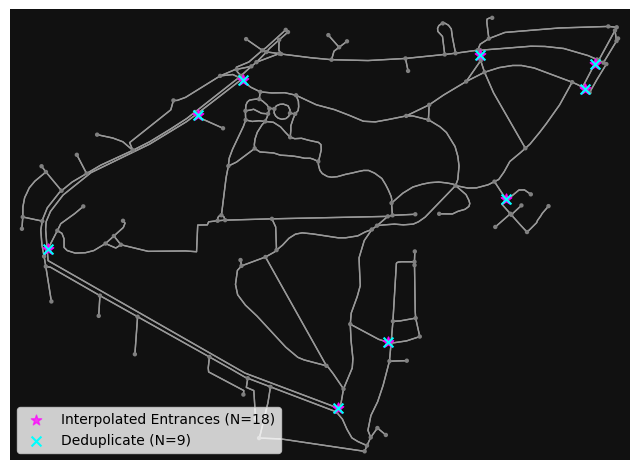

In [27]:
fig, ax = ox.plot_graph(
    G,
    node_color='gray',
    node_size=10,
    show=False,
    close=False
)



xf = [pt.x for pt in entrance_points]
yf = [pt.y for pt in entrance_points]
ax.scatter(xf, yf, c='magenta', s=60, alpha=0.7, marker='*', label=f'Interpolated Entrances (N={len(xf)})', zorder=3)

xs = [pt.x for pt in merged_points.geoms]
ys = [pt.y for pt in merged_points.geoms]
ax.scatter(xs, ys, c='cyan', s=50, marker='x', label=f'Deduplicate (N={len(xs)})', zorder=4)

ax.legend()

## Extra: compare os tagged entrances

Update the entrance tag list below to see other nodes that may be entrances, and plot these alongside the calculated nodes to compare.

In [28]:
# Tags likely to denote entrances
entrance_tags = {
    "entrance": True,
    "barrier": ["gate", "entrance"]
}

# Pull geometries tagged as entrances
entrances = ox.features.features_from_address(location, entrance_tags, 300)

# Filter to point geometries (actual entrance nodes)
entrance_points_tag = entrances[entrances.geom_type == "Point"]

print(f"Found {len(entrance_points_tag)} explicitly tagged entrance nodes.")

Found 2 explicitly tagged entrance nodes.


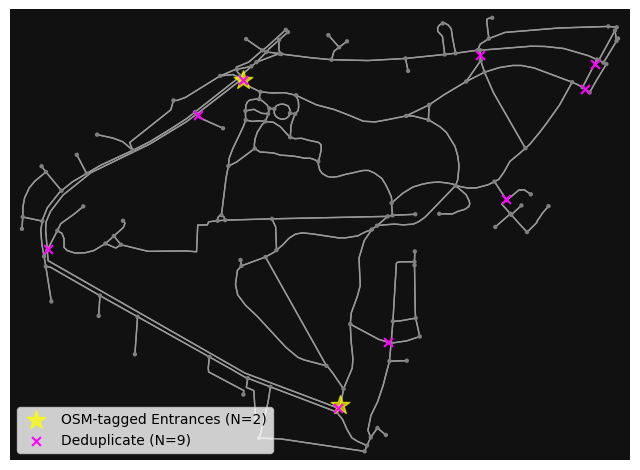

In [29]:
fig, ax = ox.plot_graph(
    G,
    node_color='gray',
    node_size=10,
    show=False,
    close=False
)



if not entrance_points_tag.empty:
    xs = entrance_points_tag.geometry.x
    ys = entrance_points_tag.geometry.y
    ax.scatter(xs, ys, c='yellow', s=200, alpha=0.7, marker='*', label=f'OSM-tagged Entrances (N={len(xs)})', zorder=4)


xs = [pt.x for pt in merged_points.geoms]
ys = [pt.y for pt in merged_points.geoms]
ax.scatter(xs, ys, c='magenta', s=40, marker='x', label=f'Deduplicate (N={len(xs)})', zorder=4)

ax.legend()